<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico 1 </font></h1>
    <h2><font style="bold">Visión por Computadora 1 - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pablo Brahim - Kevin Pennington</font></h3>
</div>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

## Parte 1
Imágenes en /white_patch

1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.

In [2]:
# Obtener todas las rutas de imágenes
image_paths = glob(os.path.join('white_patch', '*'))

# Leer imágenes
images = [cv2.imread(p) for p in image_paths]

# Convertir de BGR (OpenCV) a RGB
images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

Se evaluan los valores máximos por imagen, en caso de que el valor máximo sea 255 se debe tomar un percentil ya que el white-patch devolvería la misma imagen.

In [3]:
def get_white_patch_reference(image, use_percentile=False, percentile=98):
    # Convertir a float para evitar saturaciones
    img = image.astype(np.float32)
    
    if use_percentile:
        r_max = np.percentile(img[:, :, 0], percentile)
        g_max = np.percentile(img[:, :, 1], percentile)
        b_max = np.percentile(img[:, :, 2], percentile)
    else:
        r_max = np.max(img[:, :, 0])
        g_max = np.max(img[:, :, 1])
        b_max = np.max(img[:, :, 2])
    
    return r_max, g_max, b_max

In [4]:
for i, img in enumerate(images_rgb):
    r_max, g_max, b_max = get_white_patch_reference(img, use_percentile=False)

    print(f"Imagen {i+1}: R={r_max}, G={g_max}, B={b_max}")

Imagen 1: R=255.0, G=201.0, B=203.0
Imagen 2: R=126.0, G=252.0, B=155.0
Imagen 3: R=210.0, G=250.0, B=171.0
Imagen 4: R=255.0, G=134.0, B=122.0
Imagen 5: R=170.0, G=255.0, B=172.0
Imagen 6: R=255.0, G=255.0, B=255.0
Imagen 7: R=165.0, G=138.0, B=200.0
Imagen 8: R=247.0, G=157.0, B=175.0


Las imagenes 1, 2, 4 y 6 tienen valores máximos en 255 que harían que sature, por lo que se toma en esos casos el percentil 98.

In [14]:
def apply_white_patch(image, use_percentile=False, percentile=98):
    img = image.astype(np.float32)
    r_max, g_max, b_max = get_white_patch_reference(img, use_percentile, percentile)
    
    fuente = f"percentil {percentile}" if use_percentile else "máximo"
    print(f"Valores ({fuente}) para la corrección: R={r_max:.2f}, G={g_max:.2f}, B={b_max:.2f}")

    # Evitar división por cero
    r_max = r_max if r_max != 0 else 1
    g_max = g_max if g_max != 0 else 1
    b_max = b_max if b_max != 0 else 1

    img[:, :, 0] = np.clip(img[:, :, 0] / r_max * 255, 0, 255)
    img[:, :, 1] = np.clip(img[:, :, 1] / g_max * 255, 0, 255)
    img[:, :, 2] = np.clip(img[:, :, 2] / b_max * 255, 0, 255)

    return img.astype(np.uint8)

In [19]:
def auto_white_patch_correction(image, initial_percentile=98, min_percentile=90):
    r_max, g_max, b_max = get_white_patch_reference(image, use_percentile=False)

    if any(v == 255 for v in (r_max, g_max, b_max)):
        percentile = initial_percentile
        while percentile >= min_percentile:

            r_max, g_max, b_max = get_white_patch_reference(image, use_percentile=True, percentile=percentile)

            if all(v != 255 for v in (r_max, g_max, b_max)):
                print(f"Corrección exitosa con percentil {percentile}")
                corrected = apply_white_patch(image, use_percentile=True, percentile=percentile)
                return corrected
            
            print(f"Saturación con percentil {percentile}: R={r_max}, G={g_max}, B={b_max}")
            percentile -= 1

        print("Usando último percentil posible, puede haber saturación.")
        return corrected
    else:
        return apply_white_patch(image, use_percentile=False)

In [20]:
def show_original_vs_corrected(original, corrected, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(corrected)
    axes[1].set_title('White Patch Corrected')
    axes[1].axis('off')
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


Procesando imagen 1
Saturación con percentil 98: R=58.0, G=255.0, B=44.0
Saturación con percentil 97: R=48.0, G=255.0, B=35.0
Saturación con percentil 96: R=37.0, G=255.0, B=29.0
Saturación con percentil 95: R=30.0, G=255.0, B=24.0
Corrección exitosa con percentil 94
Valores (percentil 94) para la corrección: R=23.00, G=254.00, B=19.00


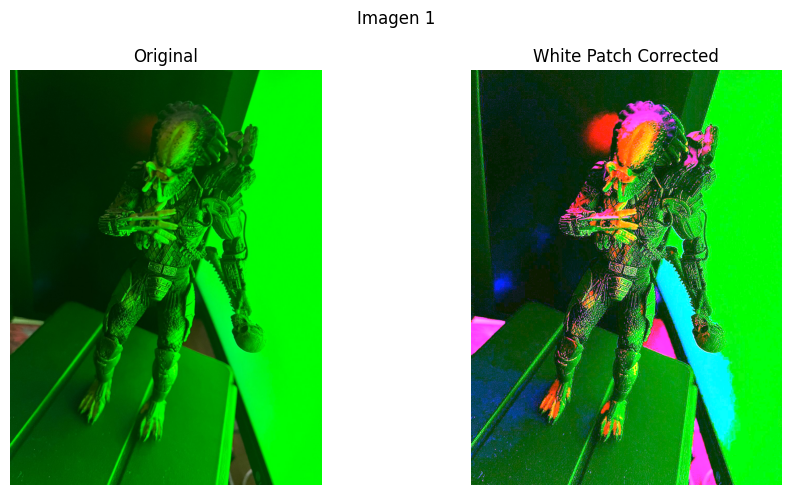


Procesando imagen 2
Saturación con percentil 98: R=255.0, G=76.0, B=101.0
Saturación con percentil 97: R=255.0, G=67.0, B=98.0
Saturación con percentil 96: R=255.0, G=62.0, B=94.0
Saturación con percentil 95: R=255.0, G=60.0, B=90.0
Saturación con percentil 94: R=255.0, G=57.0, B=87.0
Saturación con percentil 93: R=255.0, G=55.0, B=84.0
Saturación con percentil 92: R=255.0, G=53.0, B=82.0
Saturación con percentil 91: R=255.0, G=51.0, B=79.0
Corrección exitosa con percentil 90
Valores (percentil 90) para la corrección: R=254.00, G=49.00, B=77.00


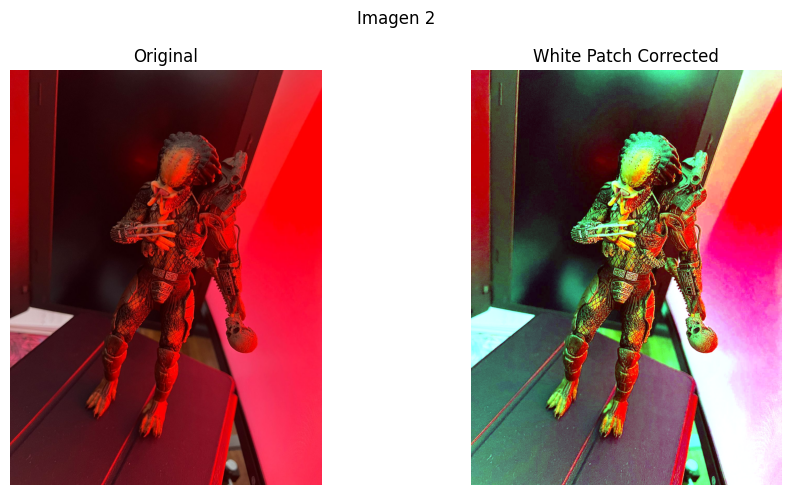


Procesando imagen 3
Valores (máximo) para la corrección: R=210.00, G=250.00, B=171.00


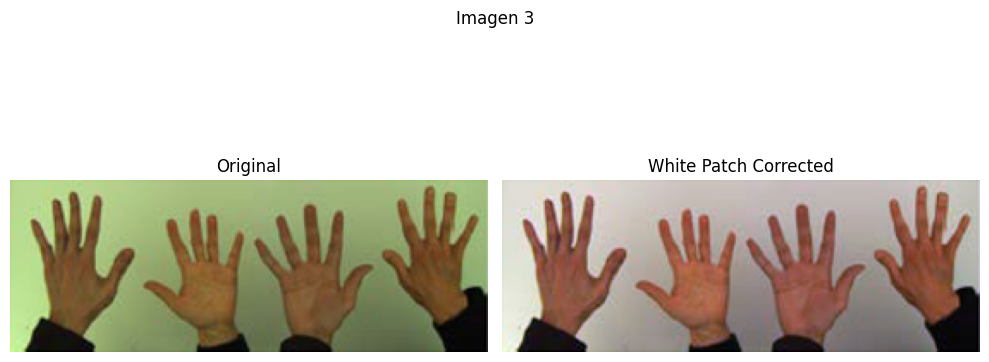


Procesando imagen 4
Saturación con percentil 98: R=255.0, G=66.0, B=99.0
Saturación con percentil 97: R=255.0, G=62.0, B=96.0
Saturación con percentil 96: R=255.0, G=59.0, B=93.0
Saturación con percentil 95: R=255.0, G=58.0, B=90.0
Saturación con percentil 94: R=255.0, G=56.0, B=86.0
Corrección exitosa con percentil 93
Valores (percentil 93) para la corrección: R=254.00, G=54.00, B=81.00


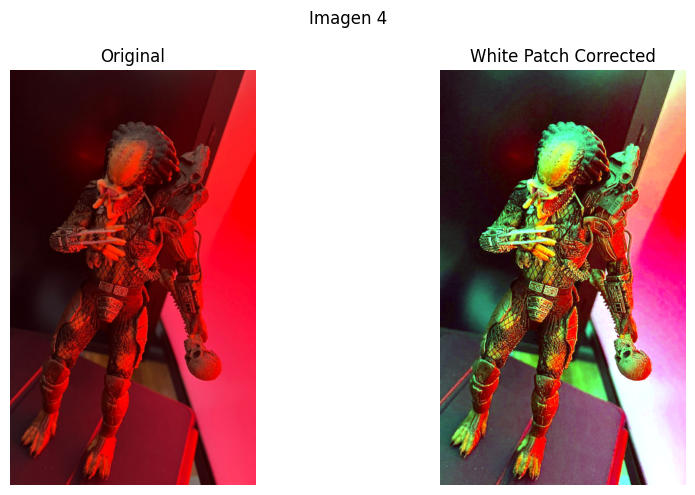


Procesando imagen 5
Valores (máximo) para la corrección: R=126.00, G=252.00, B=155.00


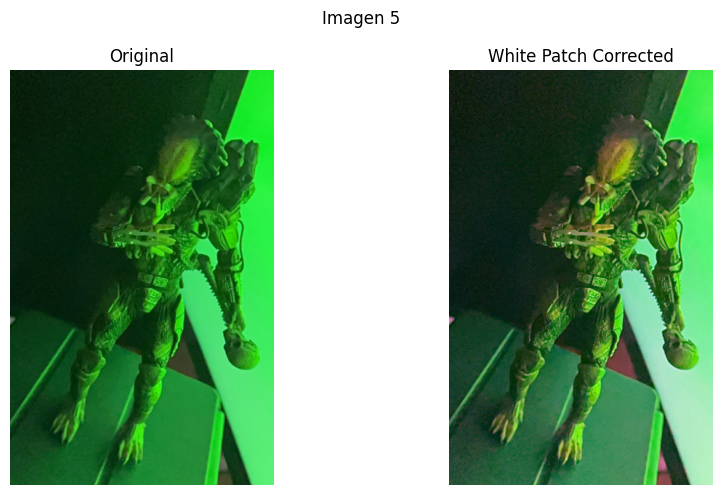


Procesando imagen 6
Corrección exitosa con percentil 98
Valores (percentil 98) para la corrección: R=86.00, G=69.00, B=253.00


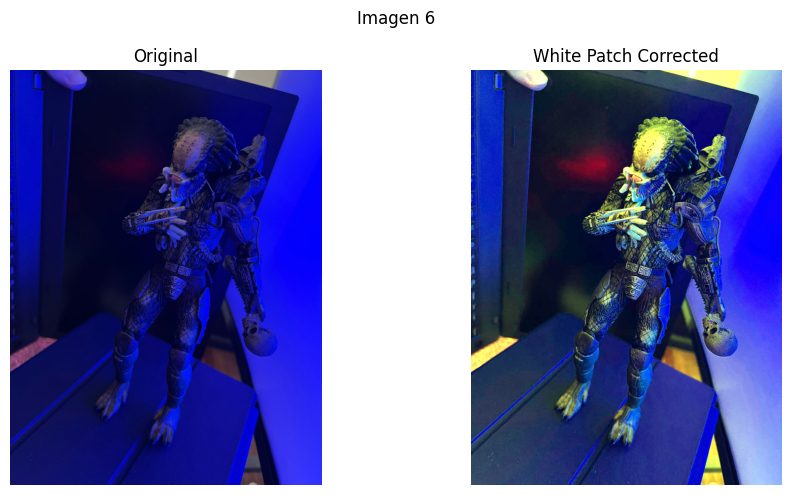


Procesando imagen 7
Valores (máximo) para la corrección: R=247.00, G=157.00, B=175.00


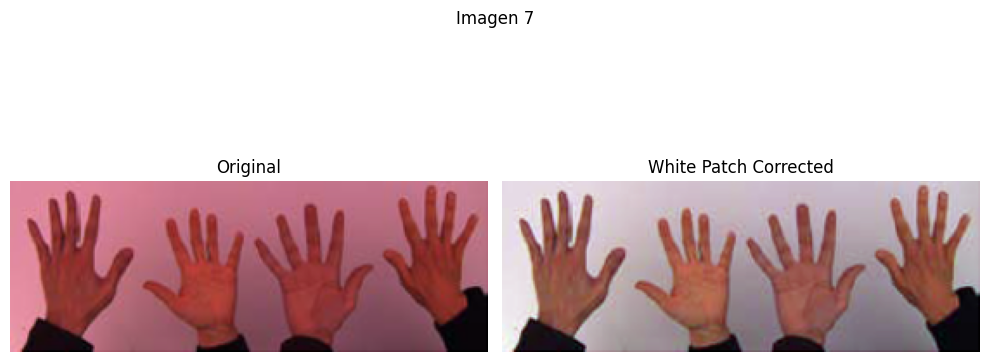


Procesando imagen 8
Valores (máximo) para la corrección: R=165.00, G=138.00, B=200.00


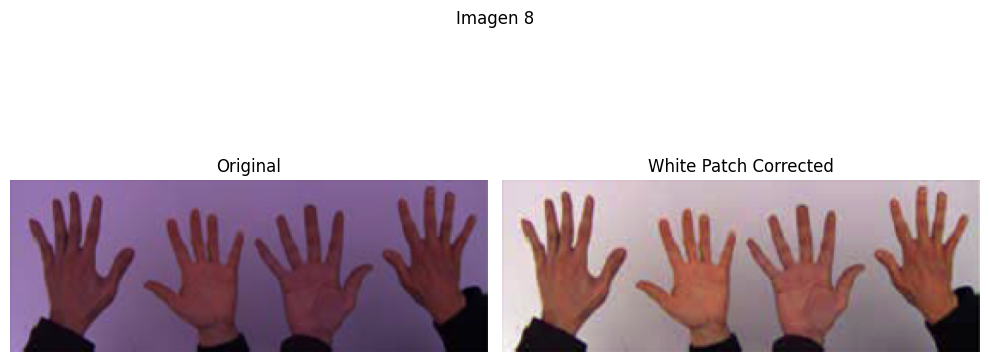

In [21]:
for i, img in enumerate(images_rgb):
    print(f"\nProcesando imagen {i+1}")
    corrected_img = auto_white_patch_correction(img, initial_percentile=98)
    show_original_vs_corrected(img, corrected_img, title=f'Imagen {i+1}')

## Parte 2
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

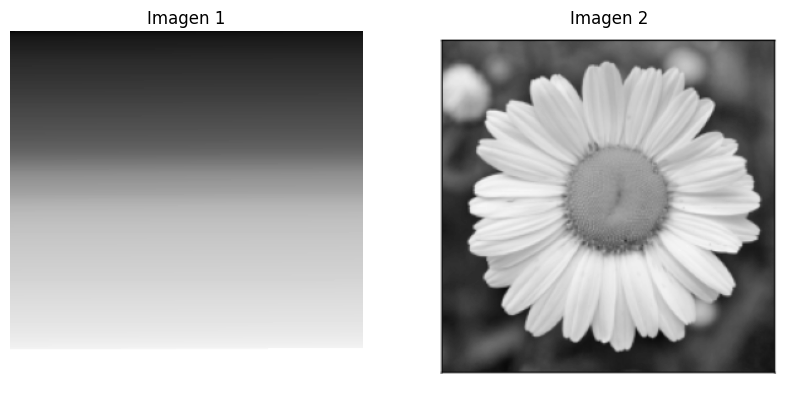

In [17]:
img1 = cv2.imread('img1_tp.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('img2_tp.png', cv2.IMREAD_GRAYSCALE)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title('Imagen 1')
axes[0].axis('off')

axes[1].imshow(img2, cmap='gray')
axes[1].set_title('Imagen 2')
axes[1].axis('off')

plt.show()

In [58]:
def plot_pair_hist(im1, im2, bin_count):
    bins = np.arange(bin_count)
    hist1 = cv2.calcHist([im1], [0], None, [bin_count], [0, 256])
    hist2 = cv2.calcHist([im2], [0], None, [bin_count], [0, 256])
    
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), 
                             gridspec_kw={'height_ratios': [5, 0.2]})
    
    axes[0, 0].fill_between(bins, hist1.flatten(), color='blue', alpha=0.6)
    axes[0, 0].set_title(f'Imagen 1 ({bin_count} bins)')
    axes[0, 0].set_ylabel('Frecuencia Normalizada')
    
    axes[0, 1].fill_between(bins, hist2.flatten(), color='red', alpha=0.6)
    axes[0, 1].set_title(f'Imagen 2 ({bin_count} bins)')
    
    gradient = np.linspace(1, 0, bin_count).reshape(1, -1)
    axes[1, 0].imshow(gradient, aspect='auto', cmap='gray', extent=[0, bin_count, 0, 1])
    axes[1, 1].imshow(gradient, aspect='auto', cmap='gray', extent=[0, bin_count, 0, 1])
    
    for ax in axes[1]:
        ax.axis('off')
    
    axes[0, 0].set_xlim([0, bin_count])
    axes[0, 1].set_xlim([0, bin_count])
    
    plt.tight_layout()
    plt.show()

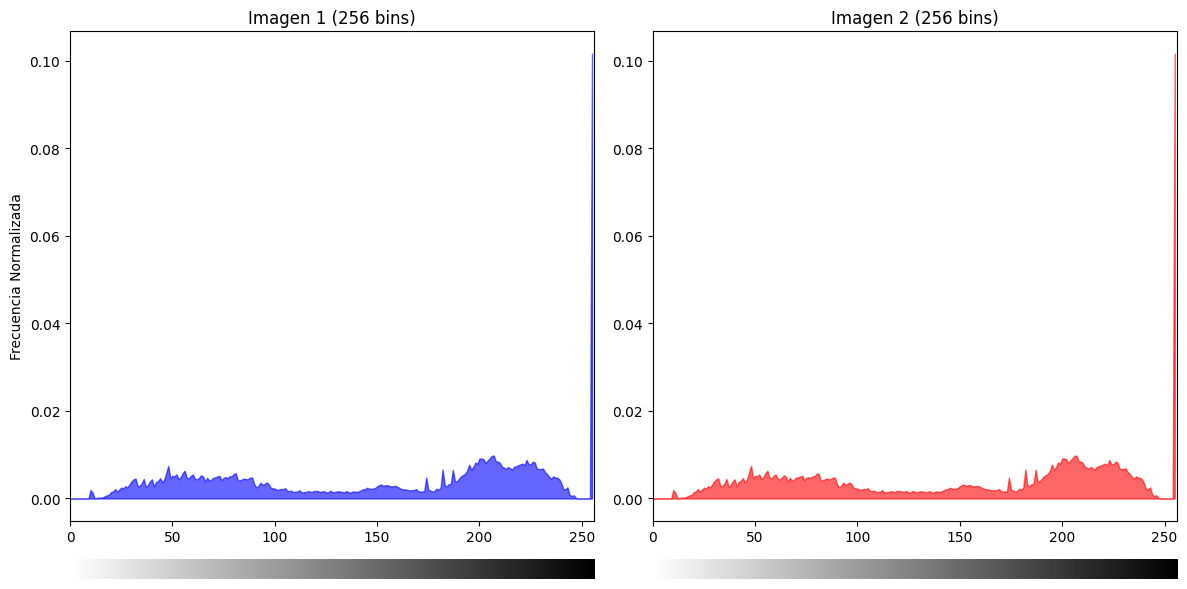

In [61]:
plot_pair_hist(img1, img2, 256)

como hay muchos pixeles negros, podemos probar con distintas distribuciones de bins